In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import torch

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 

# import BertTokenizer
from transformers import BertTokenizer, BertModel


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import Callback
import numpy as np
import pickle

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = json.load(open('../Dataset/NER_test.json'))
val_data = json.load(open('../Dataset/NER_val.json'))
test_data = json.load(open('../Dataset/NER_test.json'))

In [3]:
word2vec = pickle.load(open('Word Embeddings/word2vec.pkl', 'rb'))
glove = pickle.load(open('Word Embeddings/glove.pkl', 'rb'))
bert = pickle.load(open('Word Embeddings/bert.pkl', 'rb'))
# Add another embedding here

In [4]:
def prepareData(train_data, val_data, test_data, embedding_type):
    # Combine all datasets for consistent tokenization and vocabulary creation
    all_data = {**train_data, **val_data, **test_data}
        
    # Extract texts and labels from the combined data
    texts = [item["text"] for item in all_data.values()]
    labels = [item["labels"] for item in all_data.values()]
    
    word_tokenizer = Tokenizer()                      
    word_tokenizer.fit_on_texts(texts)                    
    
    train_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in train_data.values()])
    val_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in val_data.values()])
    test_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in test_data.values()])
 
    max_sequence_length = 50 
    vocab_size = len(word_tokenizer.word_index) + 1  # Adding 1 for the zero-padding

    X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
    X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)
    X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)


    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(labels)

    train_labels = tag_tokenizer.texts_to_sequences([item["labels"] for item in train_data.values()])
    val_labels = tag_tokenizer.texts_to_sequences([item["labels"] for item in val_data.values()])
    test_labels = tag_tokenizer.texts_to_sequences([item["labels"] for item in test_data.values()])

    max_label_length = 50    
    num_classes = len(tag_tokenizer.word_index) + 1  # Adding 1 for the zero-padding

    Y_train = pad_sequences(train_labels, maxlen=max_label_length)
    Y_val = pad_sequences(val_labels, maxlen=max_label_length)
    Y_test = pad_sequences(test_labels, maxlen=max_label_length)    

    try:
        embedding_dim = embedding_type.vector_size
    except AttributeError:
        embedding_dim = 768

    embedding_matrix = np.zeros((len(word_tokenizer.word_index) + 1, embedding_dim))
    word2id = word_tokenizer.word_index

    for word, index in word2id.items():
        try:
            embedding_matrix[index, :] = embedding_type[word]
        except IndexError:
            embedding_matrix[index, :] = embedding_type[index]
        except KeyError:
            pass       

    Y_train = to_categorical(Y_train)
    Y_val = to_categorical(Y_val)
    Y_test = to_categorical(Y_test)    

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, embedding_matrix, word_tokenizer, tag_tokenizer

In [5]:
data = {}
data['word2vec'] = {}
data['glove'] = {}
data['bert'] = {}

data['word2vec']['X_train'], data['word2vec']['X_val'], data['word2vec']['X_test'], data['word2vec']['Y_train'], data['word2vec']['Y_val'], data['word2vec']['Y_test'], data['word2vec']['vocab_size'], data['word2vec']['embedding_dim'], data['word2vec']['max_sequence_length'], data['word2vec']['num_classes'], data['word2vec']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, word2vec)
data['glove']['X_train'], data['glove']['X_val'], data['glove']['X_test'], data['glove']['Y_train'], data['glove']['Y_val'], data['glove']['Y_test'], data['glove']['vocab_size'], data['glove']['embedding_dim'], data['glove']['max_sequence_length'], data['glove']['num_classes'], data['glove']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, glove)
data['bert']['X_train'], data['bert']['X_val'], data['bert']['X_test'], data['bert']['Y_train'], data['bert']['Y_val'], data['bert']['Y_test'], data['bert']['vocab_size'], data['bert']['embedding_dim'], data['bert']['max_sequence_length'], data['bert']['num_classes'], data['bert']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, bert)

In [6]:
class MacroF1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = np.argmax(self.model.predict(self.train_data[0]), axis=-1)
        train_true = np.argmax(self.train_data[1], axis=-1)
        train_f1 = f1_score(train_true.flatten(), train_pred.flatten(), average='macro')

        val_pred = np.argmax(self.model.predict(self.val_data[0]), axis=-1)
        val_true = np.argmax(self.val_data[1], axis=-1)
        val_f1 = f1_score(val_true.flatten(), val_pred.flatten(), average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        print(f'Epoch {epoch + 1} - Train Macro-F1: {train_f1:.4f} - Val Macro-F1: {val_f1:.4f}')


## VANILLA RNN

In [7]:
def trainRNN(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    rnn_model.add(SimpleRNN(64, return_sequences=True))

    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    rnn_model.save(f'Models/t1_rnn_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Loss - {embedding} RNN')
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Macro F1 - {embedding} RNN')
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()




Epoch 1/50


45/45 [==============================] - 0s 4ms/step
Epoch 1 - Train Macro-F1: 0.0259 - Val Macro-F1: 0.0247
8/8 [==============================] - 3s 174ms/step - loss: 2.9054 - acc: 0.4601 - val_loss: 2.1281 - val_acc: 0.5278
Epoch 2/50
45/45 [==============================] - 0s 4ms/step
Epoch 2 - Train Macro-F1: 0.0415 - Val Macro-F1: 0.0405
8/8 [==============================] - 1s 118ms/step - loss: 1.7589 - acc: 0.6583 - val_loss: 1.4306 - val_acc: 0.6200
Epoch 3/50
45/45 [==============================] - 0s 4ms/step
Epoch 3 - Train Macro-F1: 0.0661 - Val Macro-F1: 0.0668
8/8 [==============================] - 1s 121ms/step - loss: 1.3292 - acc: 0.5793 - val_loss: 1.1417 - val_acc: 0.8783
Epoch 4/50
45/45 [==============================] - 0s 4ms/step
Epoch 4 - Train Macro-F1: 0.0657 - Val Macro-F1: 0.0662
8/8 [==============================] - 1s 123ms/step - loss: 1.0832 - acc: 0.8600 - val_loss: 0.9515 - val_acc: 0.8729
Epoch 5/50
45/45 [======================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


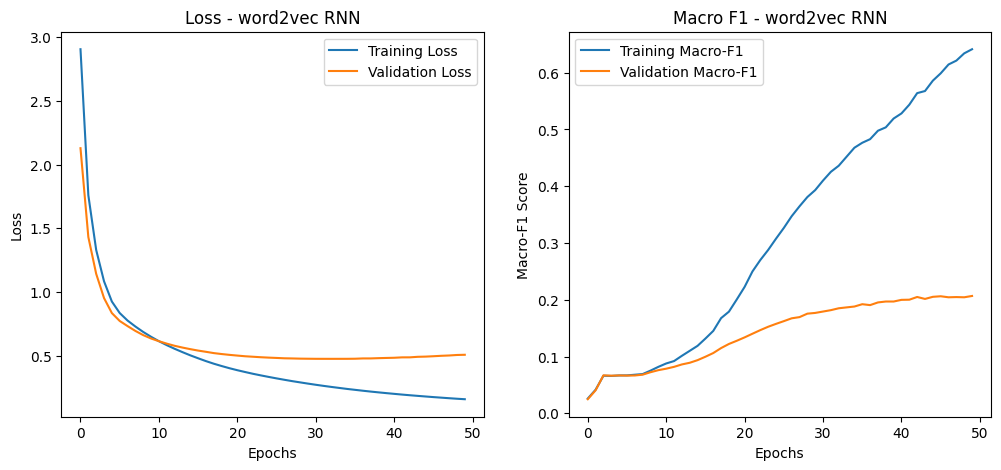

In [8]:
trainRNN('word2vec')

Epoch 1/50
45/45 [==============================] - 0s 4ms/step
Epoch 1 - Train Macro-F1: 0.0764 - Val Macro-F1: 0.0796
8/8 [==============================] - 2s 162ms/step - loss: 2.8583 - acc: 0.3930 - val_loss: 2.0997 - val_acc: 0.8373
Epoch 2/50
45/45 [==============================] - 0s 4ms/step
Epoch 2 - Train Macro-F1: 0.0704 - Val Macro-F1: 0.0688
8/8 [==============================] - 1s 116ms/step - loss: 1.7023 - acc: 0.8400 - val_loss: 1.2611 - val_acc: 0.8663
Epoch 3/50
45/45 [==============================] - 0s 4ms/step
Epoch 3 - Train Macro-F1: 0.0702 - Val Macro-F1: 0.0694
8/8 [==============================] - 1s 120ms/step - loss: 1.0963 - acc: 0.8533 - val_loss: 0.8800 - val_acc: 0.8699
Epoch 4/50
45/45 [==============================] - 0s 4ms/step
Epoch 4 - Train Macro-F1: 0.0712 - Val Macro-F1: 0.0723
8/8 [==============================] - 1s 123ms/step - loss: 0.8556 - acc: 0.8565 - val_loss: 0.7464 - val_acc: 0.8736
Epoch 5/50
45/45 [==========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


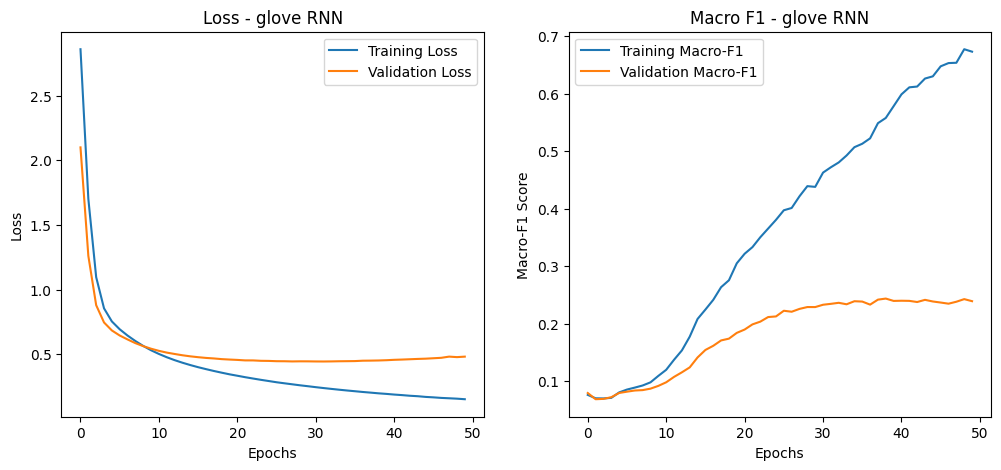

In [9]:
trainRNN('glove')

Epoch 1/50
45/45 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 3s 226ms/step - loss: 2.2055 - acc: 0.7139 - val_loss: 1.4551 - val_acc: 0.8783
Epoch 2/50
45/45 [==============================] - 0s 5ms/step
Epoch 2 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 1s 180ms/step - loss: 1.3045 - acc: 0.8594 - val_loss: 1.0617 - val_acc: 0.8783
Epoch 3/50
45/45 [==============================] - 0s 5ms/step
Epoch 3 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 1s 178ms/step - loss: 0.9729 - acc: 0.8594 - val_loss: 0.8157 - val_acc: 0.8780
Epoch 4/50
45/45 [==============================] - 0s 5ms/step
Epoch 4 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0666
8/8 [==============================] - 1s 181ms/step - loss: 0.8035 - acc: 0.8594 - val_loss: 0.7273 - val_acc: 0.8772
Epoch 5/50
45/45 [==========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


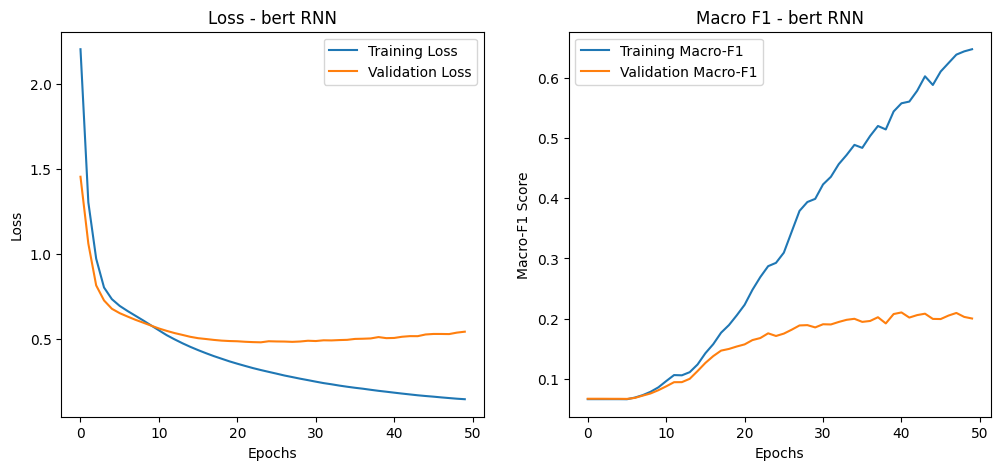

In [10]:
trainRNN('bert')

## LSTM

In [11]:
def trainLSTM(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    lstm_model.add(LSTM(64, return_sequences=True))

    lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    lstm_model.save(f'Models/t1_lstm_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Loss - {embedding} LSTM')
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Macro F1 - {embedding} LSTM')
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/50
45/45 [==============================] - 0s 7ms/step
Epoch 1 - Train Macro-F1: 0.0690 - Val Macro-F1: 0.0684
8/8 [==============================] - 4s 286ms/step - loss: 3.1937 - acc: 0.6435 - val_loss: 2.8895 - val_acc: 0.8778
Epoch 2/50
45/45 [==============================] - 0s 7ms/step
Epoch 2 - Train Macro-F1: 0.0662 - Val Macro-F1: 0.0668
8/8 [==============================] - 1s 182ms/step - loss: 2.4703 - acc: 0.8600 - val_loss: 1.8092 - val_acc: 0.8784
Epoch 3/50
45/45 [==============================] - 0s 7ms/step
Epoch 3 - Train Macro-F1: 0.0664 - Val Macro-F1: 0.0668
8/8 [==============================] - 1s 189ms/step - loss: 1.5181 - acc: 0.7536 - val_loss: 1.2165 - val_acc: 0.8788
Epoch 4/50
45/45 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.0645 - Val Macro-F1: 0.0641
8/8 [==============================] - 1s 186ms/step - loss: 1.1013 - acc: 0.8424 - val_loss: 0.9512 - val_acc: 0.8455
Epoch 5/50
45/45 [==========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


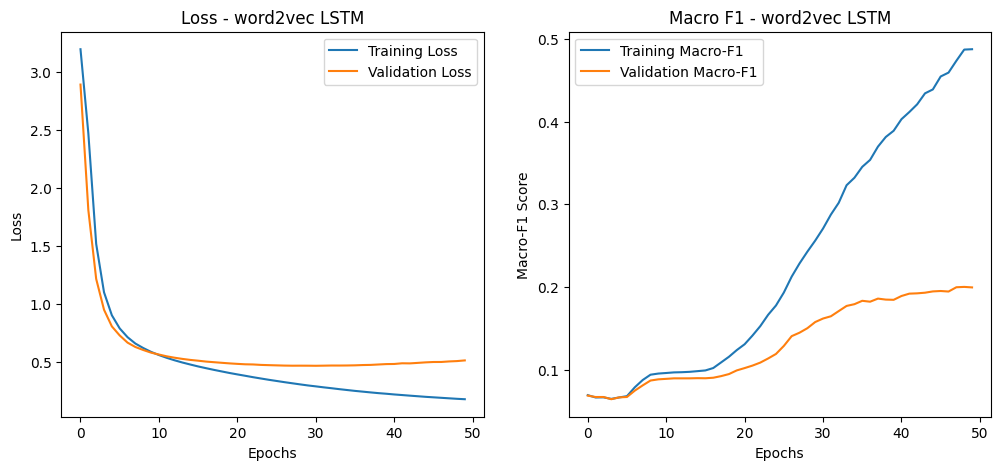

In [12]:
trainLSTM('word2vec')

Epoch 1/50
45/45 [==============================] - 0s 8ms/step
Epoch 1 - Train Macro-F1: 0.0684 - Val Macro-F1: 0.0685
8/8 [==============================] - 4s 369ms/step - loss: 2.8626 - acc: 0.7300 - val_loss: 2.2548 - val_acc: 0.8770
Epoch 2/50
45/45 [==============================] - 0s 9ms/step
Epoch 2 - Train Macro-F1: 0.0669 - Val Macro-F1: 0.0678
8/8 [==============================] - 2s 226ms/step - loss: 1.9201 - acc: 0.8592 - val_loss: 1.7258 - val_acc: 0.8779
Epoch 3/50
45/45 [==============================] - 0s 9ms/step
Epoch 3 - Train Macro-F1: 0.0670 - Val Macro-F1: 0.0686
8/8 [==============================] - 2s 225ms/step - loss: 1.5920 - acc: 0.8599 - val_loss: 1.4628 - val_acc: 0.8776
Epoch 4/50
45/45 [==============================] - 0s 9ms/step
Epoch 4 - Train Macro-F1: 0.0677 - Val Macro-F1: 0.0689
8/8 [==============================] - 2s 225ms/step - loss: 1.2706 - acc: 0.8568 - val_loss: 1.0418 - val_acc: 0.8654
Epoch 5/50
45/45 [==========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


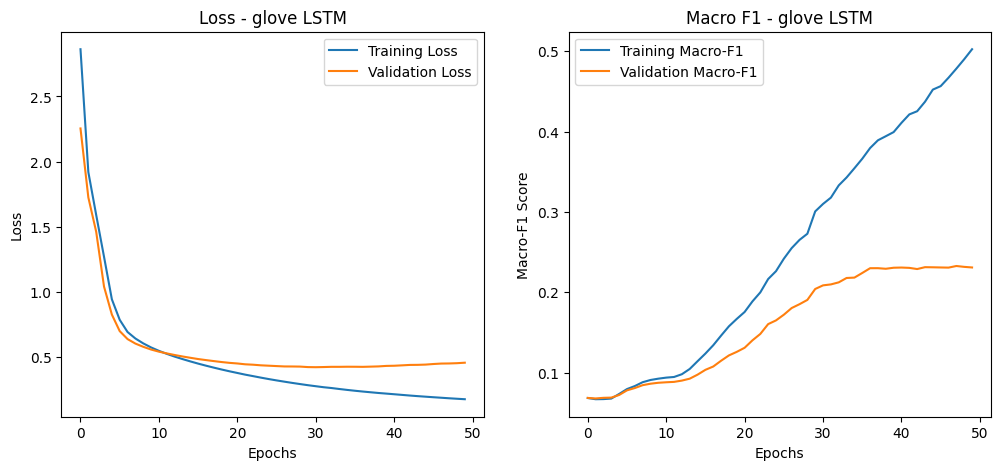

In [13]:
trainLSTM('glove')

Epoch 1/50
45/45 [==============================] - 0s 10ms/step
Epoch 1 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 5s 391ms/step - loss: 2.3564 - acc: 0.7733 - val_loss: 1.7745 - val_acc: 0.8783
Epoch 2/50
45/45 [==============================] - 0s 10ms/step
Epoch 2 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 2s 291ms/step - loss: 1.6156 - acc: 0.8594 - val_loss: 1.4761 - val_acc: 0.8783
Epoch 3/50
45/45 [==============================] - 0s 11ms/step
Epoch 3 - Train Macro-F1: 0.0659 - Val Macro-F1: 0.0665
8/8 [==============================] - 2s 290ms/step - loss: 1.2521 - acc: 0.8591 - val_loss: 0.9774 - val_acc: 0.8755
Epoch 4/50
45/45 [==============================] - 1s 11ms/step
Epoch 4 - Train Macro-F1: 0.0652 - Val Macro-F1: 0.0656
8/8 [==============================] - 2s 296ms/step - loss: 0.9016 - acc: 0.8557 - val_loss: 0.7950 - val_acc: 0.8653
Epoch 5/50
45/45 [======================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


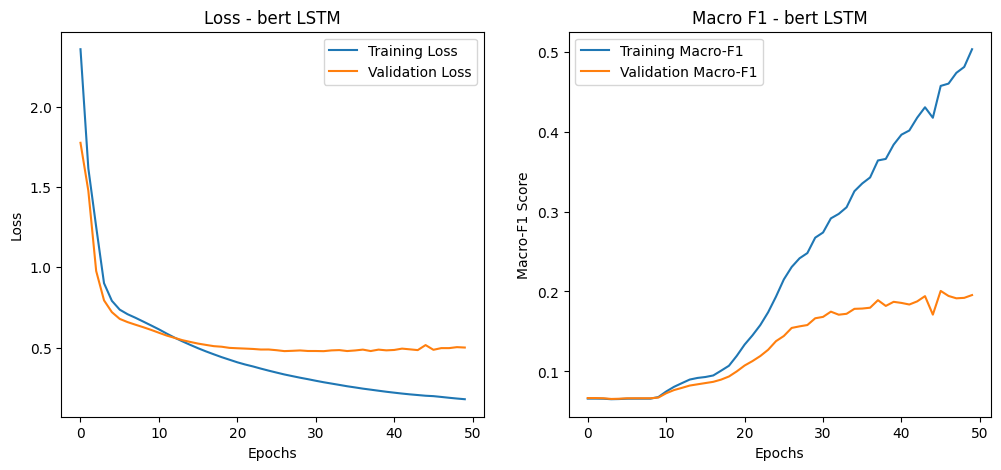

In [14]:
trainLSTM('bert')

## GRU

In [15]:
def trainGRU(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    gru_model.add(GRU(64, return_sequences=True))

    gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = gru_model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    gru_model.save(f'Models/t1_gru_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Loss - {embedding} GRU')
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Macro F1 - {embedding} GRU')
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/50
45/45 [==============================] - 0s 7ms/step
Epoch 1 - Train Macro-F1: 0.0693 - Val Macro-F1: 0.0697
8/8 [==============================] - 4s 294ms/step - loss: 3.0990 - acc: 0.7188 - val_loss: 2.7565 - val_acc: 0.8784
Epoch 2/50
45/45 [==============================] - 0s 8ms/step
Epoch 2 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 1s 203ms/step - loss: 2.3975 - acc: 0.8598 - val_loss: 1.8812 - val_acc: 0.8783
Epoch 3/50
45/45 [==============================] - 0s 8ms/step
Epoch 3 - Train Macro-F1: 0.0661 - Val Macro-F1: 0.0667
8/8 [==============================] - 1s 204ms/step - loss: 1.6351 - acc: 0.8595 - val_loss: 1.5462 - val_acc: 0.8783
Epoch 4/50
45/45 [==============================] - 0s 8ms/step
Epoch 4 - Train Macro-F1: 0.0667 - Val Macro-F1: 0.0672
8/8 [==============================] - 1s 204ms/step - loss: 1.3917 - acc: 0.8598 - val_loss: 1.1521 - val_acc: 0.8784
Epoch 5/50
45/45 [==========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


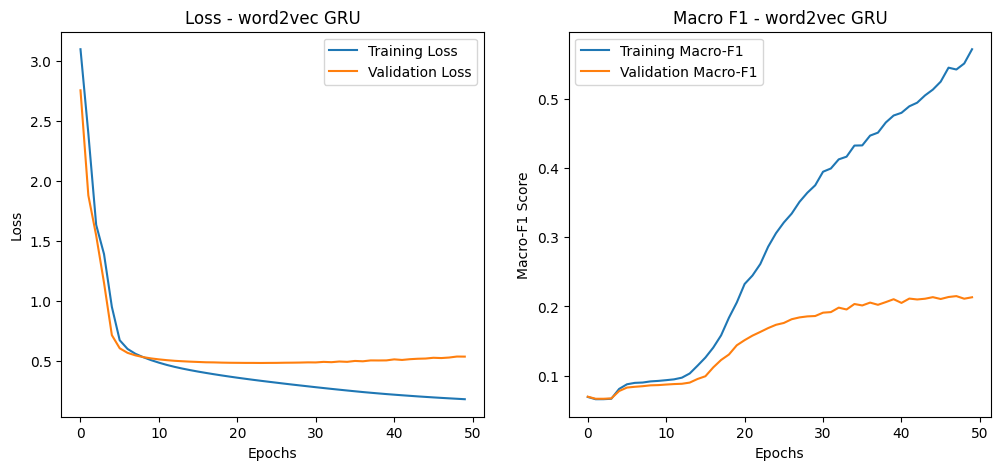

In [16]:
trainGRU('word2vec')

Epoch 1/50
45/45 [==============================] - 0s 8ms/step
Epoch 1 - Train Macro-F1: 0.0727 - Val Macro-F1: 0.0736
8/8 [==============================] - 5s 314ms/step - loss: 2.7825 - acc: 0.7269 - val_loss: 2.2047 - val_acc: 0.8736
Epoch 2/50
45/45 [==============================] - 0s 8ms/step
Epoch 2 - Train Macro-F1: 0.0696 - Val Macro-F1: 0.0715
8/8 [==============================] - 2s 214ms/step - loss: 1.8966 - acc: 0.8578 - val_loss: 1.6718 - val_acc: 0.8780
Epoch 3/50
45/45 [==============================] - 0s 8ms/step
Epoch 3 - Train Macro-F1: 0.0704 - Val Macro-F1: 0.0727
8/8 [==============================] - 2s 216ms/step - loss: 1.5424 - acc: 0.8600 - val_loss: 1.4257 - val_acc: 0.8790
Epoch 4/50
45/45 [==============================] - 0s 8ms/step
Epoch 4 - Train Macro-F1: 0.0783 - Val Macro-F1: 0.0777
8/8 [==============================] - 2s 220ms/step - loss: 1.2387 - acc: 0.8630 - val_loss: 0.9668 - val_acc: 0.8810
Epoch 5/50
45/45 [==========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


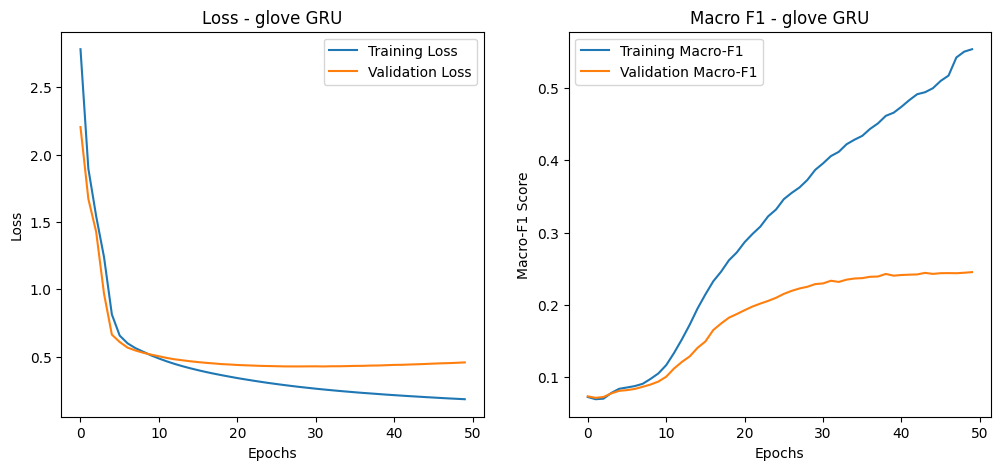

In [17]:
trainGRU('glove')

Epoch 1/50
45/45 [==============================] - 0s 9ms/step
Epoch 1 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 5s 359ms/step - loss: 2.3310 - acc: 0.7585 - val_loss: 1.7944 - val_acc: 0.8783
Epoch 2/50
45/45 [==============================] - 0s 10ms/step
Epoch 2 - Train Macro-F1: 0.0660 - Val Macro-F1: 0.0667
8/8 [==============================] - 2s 266ms/step - loss: 1.6923 - acc: 0.8594 - val_loss: 1.5299 - val_acc: 0.8783
Epoch 3/50
45/45 [==============================] - 0s 9ms/step
Epoch 3 - Train Macro-F1: 0.0658 - Val Macro-F1: 0.0662
8/8 [==============================] - 2s 264ms/step - loss: 1.3241 - acc: 0.8592 - val_loss: 1.0473 - val_acc: 0.8732
Epoch 4/50
45/45 [==============================] - 0s 9ms/step
Epoch 4 - Train Macro-F1: 0.0655 - Val Macro-F1: 0.0659
8/8 [==============================] - 2s 263ms/step - loss: 0.8947 - acc: 0.8535 - val_loss: 0.7229 - val_acc: 0.8686
Epoch 5/50
45/45 [=========================

C:\Users\mishr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


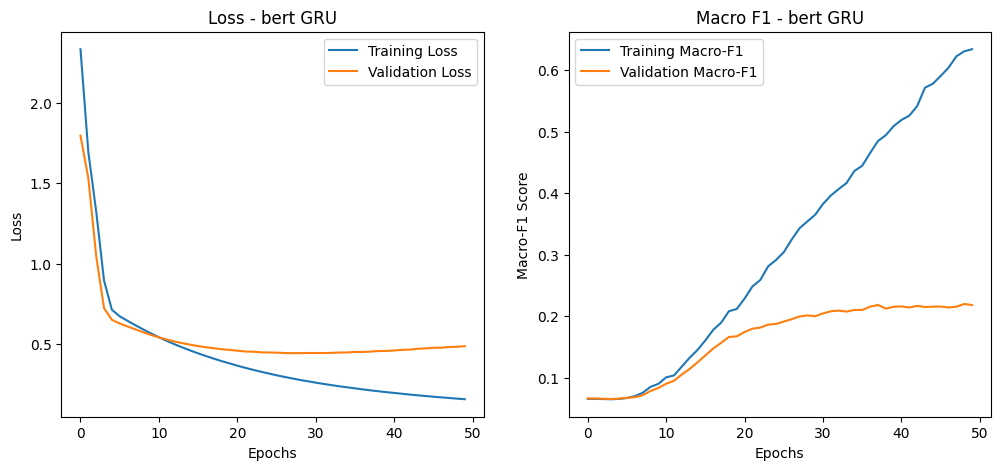

In [18]:
trainGRU('bert')

## EVALUATION

In [19]:
def get_aspect_terms(test_pred, X_test):
    aspect_terms = []
    for i in range(len(test_pred)):
        aspect_term = []
        for j in range(len(test_pred[i])):
            if test_pred[i][j] == 1:
                aspect_term.append(word_tokenizer.index_word[X_test[i][j]])
        aspect_terms.append(aspect_term)
    return aspect_terms

In [20]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = np.argmax(model.predict(X_test), axis=-1)
    Y_true = np.argmax(Y_test, axis=-1)

    aspect_terms = get_aspect_terms(Y_pred, X_test)

    print(f'Macro F1 Score: {f1_score(Y_true.flatten(), Y_pred.flatten(), average="macro"):.4f}')
    print(f'Accuracy: {accuracy_score(Y_true.flatten(), Y_pred.flatten())*100:.2f}%')

    return aspect_terms

In [22]:
rnn_word2vec = load_model('Models/t1_rnn_word2vec.h5')
rnn_glove = load_model('Models/t1_rnn_glove.h5')
rnn_bert = load_model('Models/t1_rnn_bert.h5')

lstm_word2vec = load_model('Models/t1_lstm_word2vec.h5')
lstm_glove = load_model('Models/t1_lstm_glove.h5')
lstm_bert = load_model('Models/t1_lstm_bert.h5')

gru_word2vec = load_model('Models/t1_gru_word2vec.h5')
gru_glove = load_model('Models/t1_gru_glove.h5')
gru_bert = load_model('Models/t1_gru_bert.h5')


print("RNN Word2Vec")
rnn_word2vec_aspect_terms = evaluate_model(rnn_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("RNN Glove")
rnn_glove_aspect_terms = evaluate_model(rnn_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("RNN bert")
rnn_bert_aspect_terms = evaluate_model(rnn_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("LSTM Word2Vec")
lstm_word2vec_aspect_terms = evaluate_model(lstm_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("LSTM Glove")
lstm_glove_aspect_terms = evaluate_model(lstm_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("LSTM bert")
lstm_bert_aspect_terms = evaluate_model(lstm_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("GRU Word2Vec")
gru_word2vec_aspect_terms = evaluate_model(gru_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("GRU Glove")
gru_glove_aspect_terms = evaluate_model(gru_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("GRU bert")
gru_bert_aspect_terms = evaluate_model(gru_bert, data['bert']['X_test'], data['bert']['Y_test'])

RNN Word2Vec
30/30 [==============================] - 0s 6ms/step
Macro F1 Score: 0.6414
Accuracy: 96.24%

RNN Glove
30/30 [==============================] - 0s 6ms/step
Macro F1 Score: 0.6729
Accuracy: 96.21%

RNN bert
30/30 [==============================] - 0s 7ms/step
Macro F1 Score: 0.6481
Accuracy: 96.33%

LSTM Word2Vec
30/30 [==============================] - 1s 11ms/step
Macro F1 Score: 0.4876
Accuracy: 95.04%

LSTM Glove
30/30 [==============================] - 1s 13ms/step
Macro F1 Score: 0.5025
Accuracy: 94.99%

LSTM bert
30/30 [==============================] - 1s 12ms/step
Macro F1 Score: 0.5030
Accuracy: 95.16%

GRU Word2Vec
30/30 [==============================] - 1s 8ms/step
Macro F1 Score: 0.5713
Accuracy: 95.00%

GRU Glove
30/30 [==============================] - 1s 8ms/step
Macro F1 Score: 0.5538
Accuracy: 94.88%

GRU bert
30/30 [==============================] - 1s 11ms/step
Macro F1 Score: 0.6336
Accuracy: 95.82%
